# Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
import regex as re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Quora_Duplicate_Questions.src.functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = 'drive/MyDrive/Quora_Duplicate_Questions/'
data = pd.read_csv(PATH+'src/train.csv', index_col='id')

# Basic Data Analysis

In [ ]:
data.shape

(404290, 5)

In [ ]:
data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [ ]:
data.isnull().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

Instead of dropping the nulls, we will fill them with an empty string. This way the model will be robust towards an empty string if there is no blank question prevention in place

In [ ]:
data.fillna(' ', inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404290 non-null  object
 3   question2     404290 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


We see saw there were three missing values which were dropped. The binary target is int64 which we can cast as int8 to save memory and speed computations.

In [ ]:
data['is_duplicate'] = data['is_duplicate'].astype('int8')

# Target Analysis

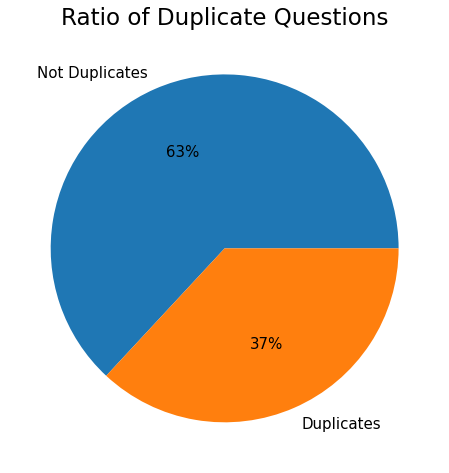

In [ ]:
not_dup = data[data['is_duplicate'] == 0].shape[0]
dup = data[data['is_duplicate'] == 1].shape[0]

plt.figure(figsize=(8, 8))
plt.pie(x=[not_dup, dup], labels=['Not Duplicates', 'Duplicates'], autopct='%.0f%%', colors=sns.color_palette('tab10'), textprops={'fontsize': 15})
plt.title('Ratio of Duplicate Questions', fontsize=23)
plt.show()

- There is a slight class imbalance, not enough to do anything to fix it

# Questions Analysis

## Repeats

In [ ]:
qidsnot = pd.Series(data[data['is_duplicate']==0]['qid1'].tolist() + data[data['is_duplicate']==0]['qid2'].tolist())
unique_qsnot = len(qidsnot.unique())
repeatsnot = np.sum(qidsnot.value_counts() > 1)
qidsdup = pd.Series(data[data['is_duplicate']==1]['qid1'].tolist() + data[data['is_duplicate']==1]['qid2'].tolist())
unique_qdup = len(qidsdup.unique())
repeatsdup = np.sum(qidsdup.value_counts() > 1)
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(qids.unique())
repeats = np.sum(qids.value_counts() > 1)
print('Not Duplicated')
print(f'Number of unique questions: {unique_qsnot} ({unique_qsnot/(unique_qsnot+unique_qdup)*100:.2f}%)\n'
f'Number of questions repeated: {repeatsnot} ({repeatsnot/(repeatsnot+repeatsdup)*100:.2f}%)\n'
f'Max amount repeated: {max(qidsnot.value_counts())}\n', '====='*10)
print(f'Duplicated\nNumber of unique questions: {unique_qdup} ({unique_qdup/(unique_qdup+unique_qsnot)*100:.2f}%)\n'
f'Number of questions repeated: {repeatsdup} ({repeatsdup/(repeatsdup+repeatsnot)*100:.2f}%)\n'
f'Max amount repeated: {max(qidsdup.value_counts())}\n', '====='*10)
print(f'Whole Dataset\nNumber of unique questions: {unique_qs}\nNumber of questions repeated: {repeats}\nMax amount repeated: {max(qids.value_counts())}')

Not Duplicated
Number of unique questions: 413109 (73.41%)
Number of questions repeated: 57991 (55.75%)
Max amount repeated: 120
Duplicated
Number of unique questions: 149650 (26.59%)
Number of questions repeated: 46032 (44.25%)
Max amount repeated: 56
Whole Dataset
Number of unique questions: 537933
Number of questions repeated: 111780
Max amount repeated: 157


- There are more repeated questions in the duplicated category than there should be according to the distribution of is_duplicate

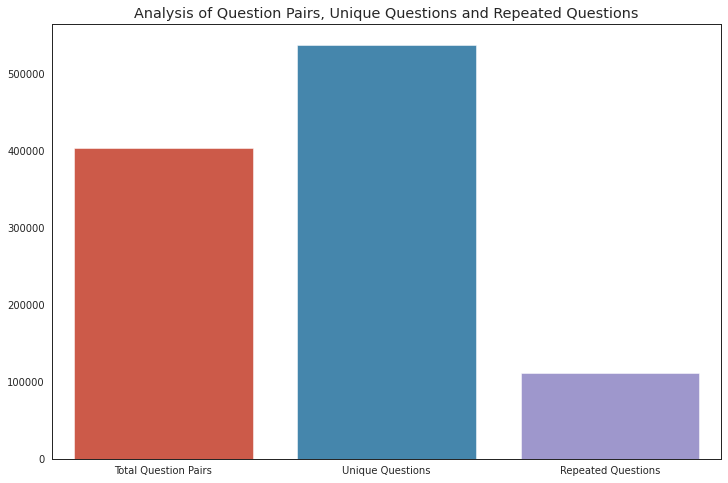

In [ ]:
pairs_queried = data.shape[0]

plt.figure(figsize=(12, 8))
sns.barplot(x=['Total Question Pairs', 'Unique Questions', 'Repeated Questions'], y=[pairs_queried, unique_qs, repeats])
plt.title('Analysis of Question Pairs, Unique Questions and Repeated Questions')
plt.show()

## Duplicate question pairs

In [ ]:
np.sum(data[['qid1','qid2']].groupby(['qid1','qid2']).size() > 1)

0

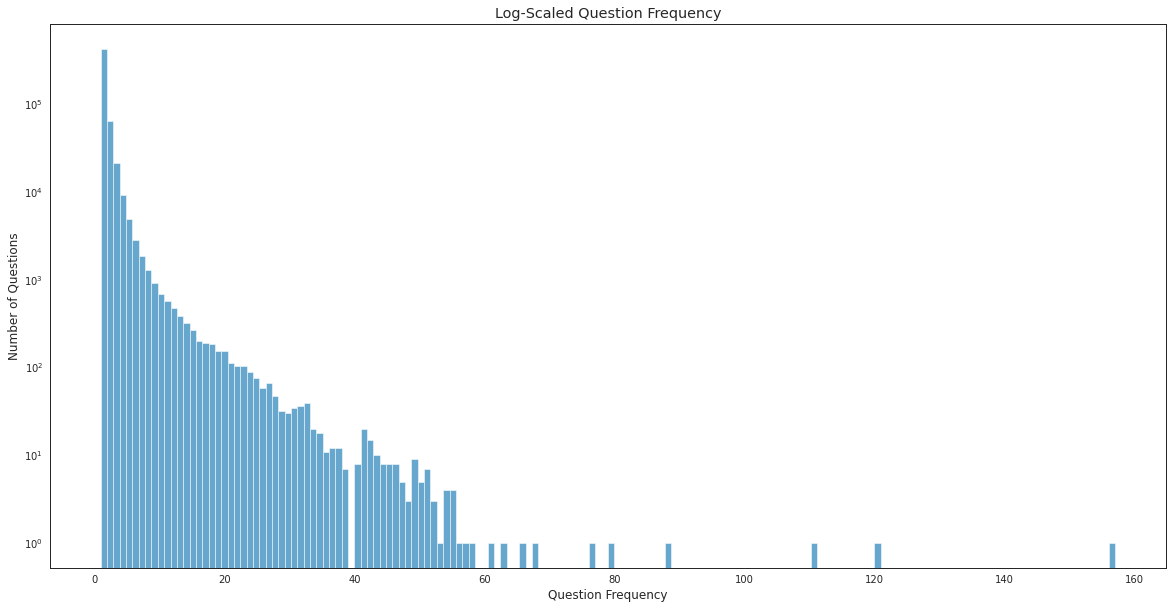

In [ ]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.histplot(qids.value_counts(), bins=160, log_scale=[False, True])
plt.title('Log-Scaled Question Frequency')
plt.xlabel('Question Frequency')
plt.ylabel('Number of Questions')
plt.show()

- The vast majority of questions are only repeated a few times
- Long tailed distribution with singular questions being repeated from ~60 to ~160

# Basic Feature Engineering
- These basic features are just some statistics so I am doing it here instead of a different notebook

In [ ]:
data['q1_len'] = data['question1'].str.len()
data['q2_len'] = data['question2'].str.len()
data['len_difference'] = data['q1_len'] - data['q2_len']
data['len_abs_difference'] = abs(data['q1_len'] - data['q2_len'])

data['q1_freq'] = data.groupby('qid1')['qid1'].transform('count')
data['q2_freq'] = data.groupby('qid2')['qid2'].transform('count')
data['total_freq'] = data['q1_freq'] + data['q2_freq']
data['abs_diff_freq'] = abs(data['q1_freq'] - data['q2_freq'])

data['q1_num_words'] = data['question1'].apply(lambda x: len(x.split()))
data['q2_num_words'] = data['question2'].apply(lambda x: len(x.split()))

data['q1_char_len'] = data['question1'].apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
data['q2_char_len'] = data['question2'].apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))

data['num_common_words'] = data.apply(lambda x: len(set(x['question1'].lower().split()).intersection(set(x['question2'].lower().split()))), axis=1)
data['ratio_common_words'] = data.apply(lambda x: len(set(x['question1'].lower().split()).intersection(set(x['question2'].lower().split()))) / (x['q1_num_words'] + x['q2_num_words']), axis=1)

feat_set_1 = data.loc[:, 'q1_len':].columns.tolist()

# Analysis of Engineered Features

In [ ]:
data[feat_set_1].describe().T

,count,mean,std,min,25%,50%,75%,max
q1_len,404290.0,59.536711,29.940650,1.0,39.000000,52.000000,72.0000,623.0
q2_len,404290.0,60.108370,33.863862,1.0,39.000000,51.000000,72.0000,1169.0
len_difference,404290.0,-0.571659,32.566696,-1080.0,-11.000000,0.000000,12.0000,487.0
len_abs_difference,404290.0,20.158193,25.584424,0.0,4.000000,12.000000,26.0000,1080.0
q1_freq,404290.0,2.827609,4.487418,1.0,1.000000,1.000000,3.0000,50.0
q2_freq,404290.0,3.046961,6.026871,1.0,1.000000,1.000000,2.0000,120.0
total_freq,404290.0,5.874570,9.091068,2.0,2.000000,3.000000,5.0000,157.0
abs_diff_freq,404290.0,1.845715,5.187882,0.0,0.000000,0.000000,2.0000,119.0
q1_num_words,404290.0,10.942207,5.428828,0.0,7.000000,10.000000,13.0000,125.0
q2_num_words,404290.0,11.181986,6.305254,0.0,7.000000,10.000000,13.0000,237.0


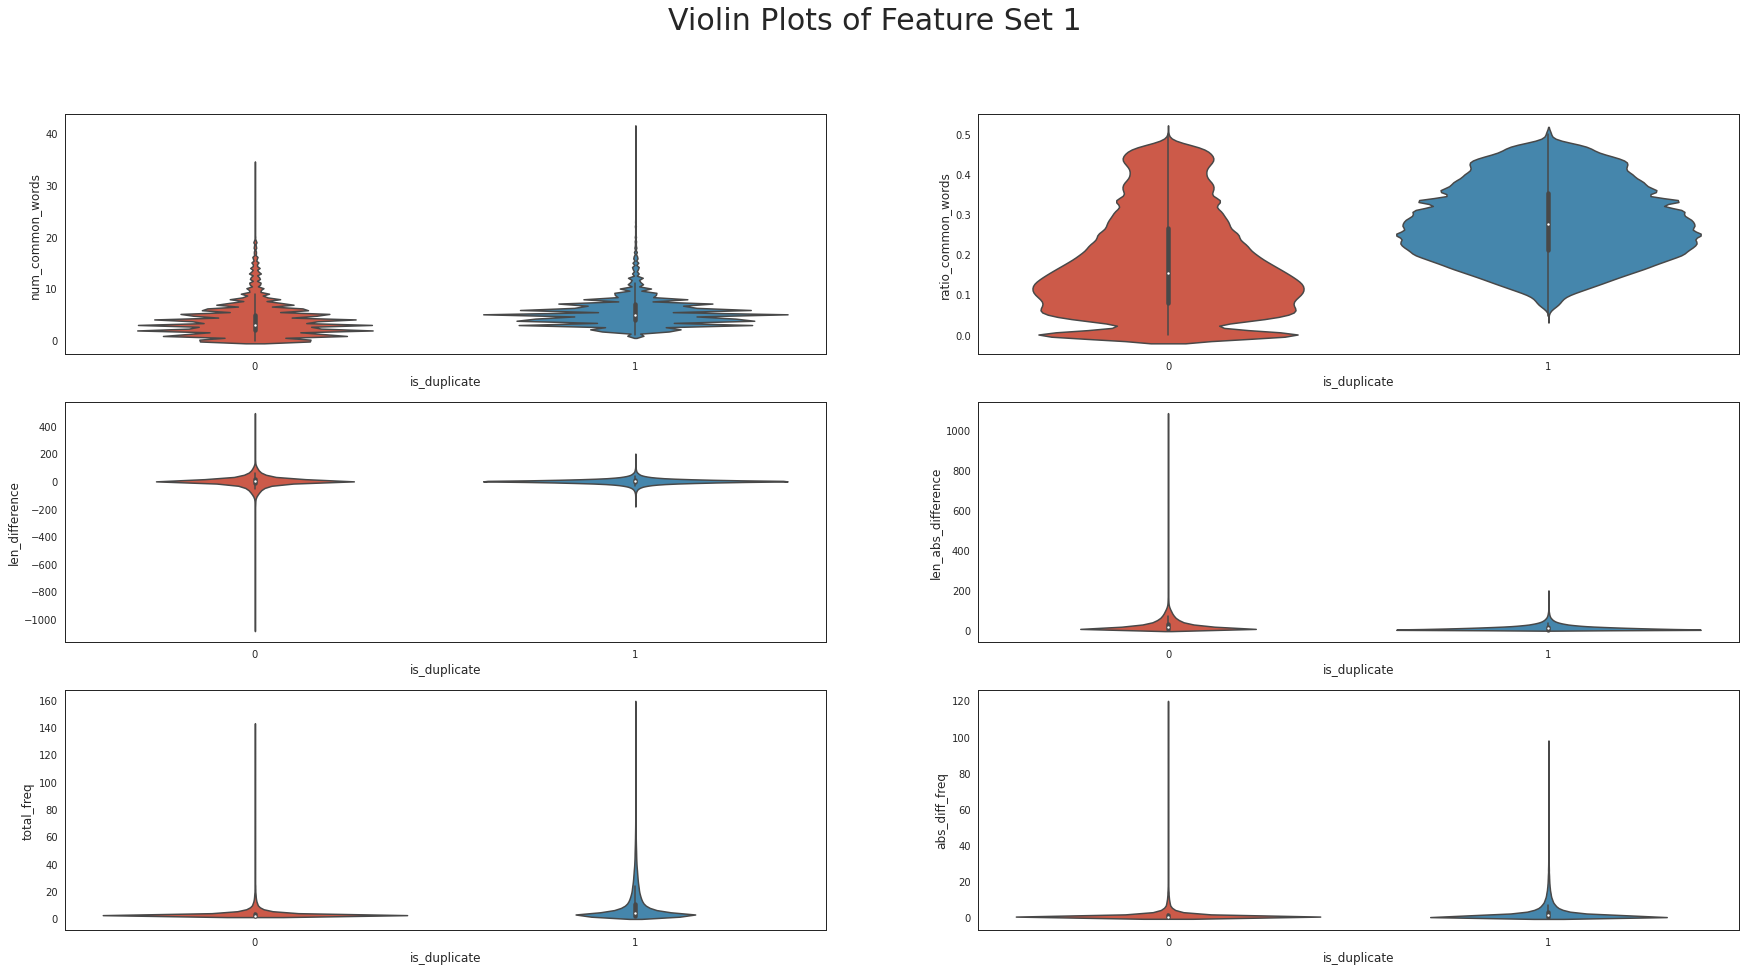

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(30, 15))
axes = axes.ravel()
sns.violinplot(data=data, x='is_duplicate', y='num_common_words', ax=axes[0])
sns.violinplot(data=data, x='is_duplicate', y='ratio_common_words', ax=axes[1])
sns.violinplot(data=data, x='is_duplicate', y='len_difference', ax=axes[2])
sns.violinplot(data=data, x='is_duplicate', y='len_abs_difference', ax=axes[3])
sns.violinplot(data=data, x='is_duplicate', y='total_freq', ax=axes[4])
sns.violinplot(data=data, x='is_duplicate', y='abs_diff_freq', ax=axes[5])
plt.suptitle('Violin Plots of Feature Set 1', fontsize=30)
plt.show()

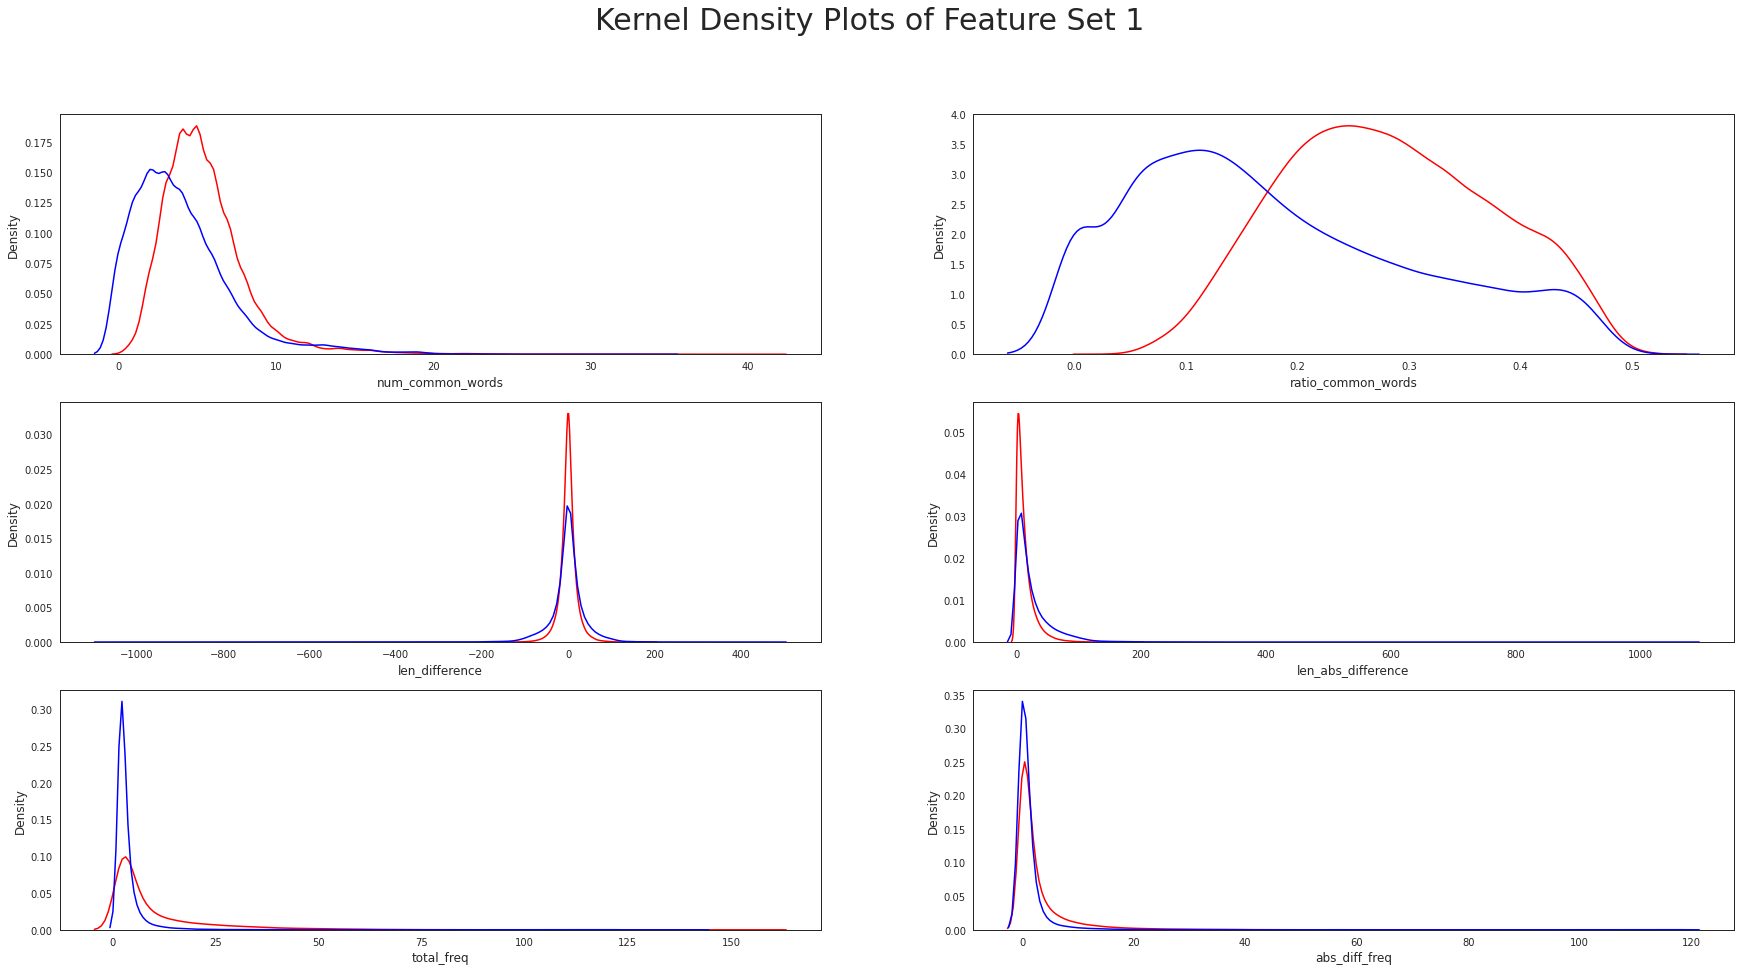

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(30, 15))
axes = axes.ravel()
sns.kdeplot(data[data['is_duplicate']==1]['num_common_words'], label='1', color='r', ax=axes[0], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==0]['num_common_words'], label='0', color='b', ax=axes[0], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==1]['ratio_common_words'], label='1', color='r', ax=axes[1], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==0]['ratio_common_words'], label='0', color='b', ax=axes[1], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==1]['len_difference'], label='1', color='r', ax=axes[2], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==0]['len_difference'], label='0', color='b', ax=axes[2], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==1]['len_abs_difference'], label='1', color='r', ax=axes[3], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==0]['len_abs_difference'], label='0', color='b', ax=axes[3], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==1]['total_freq'], label='1', color='r', ax=axes[4], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==0]['total_freq'], label='0', color='b', ax=axes[4], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==1]['abs_diff_freq'], label='1', color='r', ax=axes[5], bw_adjust=1.9)
sns.kdeplot(data[data['is_duplicate']==0]['abs_diff_freq'], label='0', color='b', ax=axes[5], bw_adjust=1.9)
plt.suptitle('Kernel Density Plots of Feature Set 1', fontsize=30)
plt.show()

# Summary
- There is a slight class imbalance (63% not duplicates to 37% duplicates)
- There are slightly more repeated questions in duplicates according to the class distribution
- The repeated questions appear to follow a power normal distribution
- From the engineered features, only the number and ratio of common words look like they will be effective predictors